<h1 align="center"><span style='font-family:arial'>Farm Relief Customer Segmentation Analysis 2</h1>

<h4 align="center"><span style='font-family:arial'>February 2023</h4>

# Overview

Using the data that had already been cleaned from project 1.

    - We will automate various processes in this project.
    - In terms of connection, we'll take the csv file, link it to SQL Server, import it back into the notebook, create 
    a DataFrame from the SQL file, perform analysis, and finally export the file back to SQL Server and to csv.



# Problem Definition

In this investigation, we will segment our participants by investigating their behavior patterns and gleaning some insights into their common qualities before grouping them.



# Data Preparation

In [1]:
# libraries

import warnings
warnings.filterwarnings('ignore')

import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import explained_variance_score
from math import sqrt

from sklearn.cluster import KMeans, k_means

%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

### Loading Raw Data

In [2]:
# loading the data
data = pd.read_csv('farm_relief_clean.csv')
print('shape of data: ', data.shape)
data.head()

shape of data:  (59, 14)


,Age Range,Age,Gender,Occupation,Marital status,Income,Monthly Household Income,Location,Device Type,Delivery Method,Farmer,Farm Produce,Online Platform,Alternative Platform Knowledge
0,18 - 25,21,Female,Student,Single,5000.0,< 50000,Modakeke,Android,Home Delivery,No,"Garri,Rice,Pepper,Onion,Vegetables",Yes,No
1,50 and above,57,Female,Student,Married,120000.0,100000 - 200000,Osun,Android,Home Delivery,No,"Pepper, Vegetables, Plantain, Charcoal, Yam fl...",Yes,No
2,50 and above,57,Male,Farmer,Married,155000.0,100000 - 200000,Osun,Android,Home Delivery,Yes,Cocoa,Yes,No
3,18 - 25,23,Male,Student,Single,15000.0,< 50000,Ekiti,Android,Home Delivery,No,"Vegetables,Rice",Yes,Maybe
4,26 - 35,28,Male,Freelance copywriter,Single,300000.0,200000 - 500000,Ibadan,Android,Home Delivery,No,"Vegetables,Grains",Yes,No


In [3]:
#%pip install pypyodbc

In [4]:
# fetching file from SQL Server

import pypyodbc as podbc

conn2 = podbc.connect("Driver={SQL Server};"
                     "Server=DESKTOP-A819NEQ\SQLEXPRESS;"
                     "Database=Women Techsters;"
                     "Trusted_Connection=yes;")

# running sql query to select the table and all its contents
SQL_Query = pd.read_sql_query('''SELECT * FROM [dbo].[farm_relief_clean];''', conn2)

# first 5 rows 
SQL_Query.head()

,age_range,age,gender,occupation,marital_status,income,monthly_household_income,location,device_type,delivery_method,farmer,farm_produce,online_platform,alternative_platform_knowledge
0,18 - 25,21,Female,Student,Single,5000.0,< 50000,Modakeke,Android,Home Delivery,No,"Garri,Rice,Pepper,Onion,Vegetables",Yes,No
1,50 and above,57,Female,Student,Married,120000.0,100000 - 200000,Osun,Android,Home Delivery,No,"Pepper, Vegetables, Plantain, Charcoal, Yam fl...",Yes,No
2,50 and above,57,Male,Farmer,Married,155000.0,100000 - 200000,Osun,Android,Home Delivery,Yes,Cocoa,Yes,No
3,18 - 25,23,Male,Student,Single,15000.0,< 50000,Ekiti,Android,Home Delivery,No,"Vegetables,Rice",Yes,Maybe
4,26 - 35,28,Male,Freelance copywriter,Single,300000.0,200000 - 500000,Ibadan,Android,Home Delivery,No,"Vegetables,Grains",Yes,No


## Data Preprocessing

### Exploratory Data Analysis & Wrangling

In [5]:
# checking null values

SQL_Query.isnull().sum()


age_range                         0
age                               0
gender                            0
occupation                        0
marital_status                    0
income                            0
monthly_household_income          0
location                          0
device_type                       0
delivery_method                   0
farmer                            0
farm_produce                      0
online_platform                   0
alternative_platform_knowledge    0
dtype: int64

In [6]:
# looking at all the distinct elements in each feature

for column in SQL_Query:
    unique_vals = np.unique(SQL_Query[column])
    nb_values = len(unique_vals)
    if nb_values < 10:
        print('Unique values for {} :{} -- {}'.format(column, nb_values,unique_vals))
    else:
        print('Unique values for {} :{}'.format(column, nb_values))

Unique values for age_range :4 -- ['18 - 25' '26 - 35' '35 - 49' '50 and above']
Unique values for age :26
Unique values for gender :2 -- ['Female' 'Male']
Unique values for occupation :22
Unique values for marital_status :2 -- ['Married' 'Single']
Unique values for income :38
Unique values for monthly_household_income :6 -- ['100000 - 200000' '200000 - 500000' '50000 - 100000' '500000 - 1000000'
 '< 50000' '> 1000000']
Unique values for location :13
Unique values for device_type :2 -- ['Android' 'iPhone']
Unique values for delivery_method :4 -- ['Home Delivery' 'Market' 'Not Specified' 'Pick-up']
Unique values for farmer :2 -- ['No' 'Yes']
Unique values for farm_produce :51
Unique values for online_platform :3 -- ['No' 'Not Specified' 'Yes']
Unique values for alternative_platform_knowledge :3 -- ['Maybe' 'No' 'Yes']


In [7]:
# a look at the columns

SQL_Query.columns

Index(['age_range', 'age', 'gender', 'occupation', 'marital_status', 'income',
       'monthly_household_income', 'location', 'device_type',
       'delivery_method', 'farmer', 'farm_produce', 'online_platform',
       'alternative_platform_knowledge'],
      dtype='object')

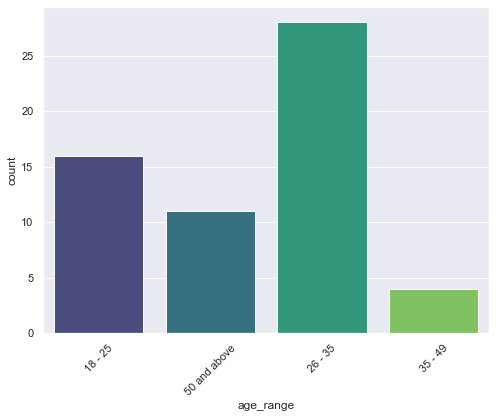

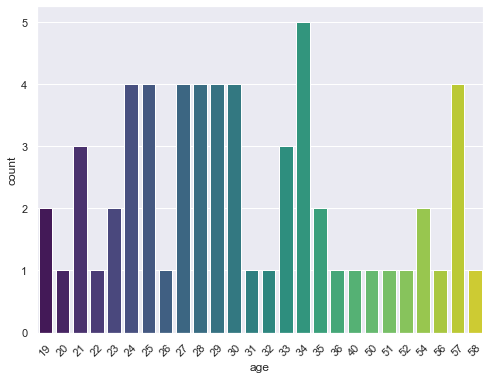

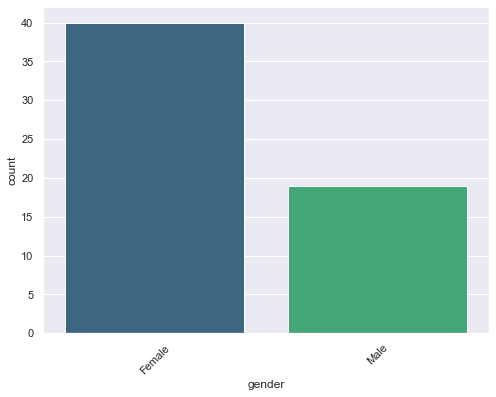

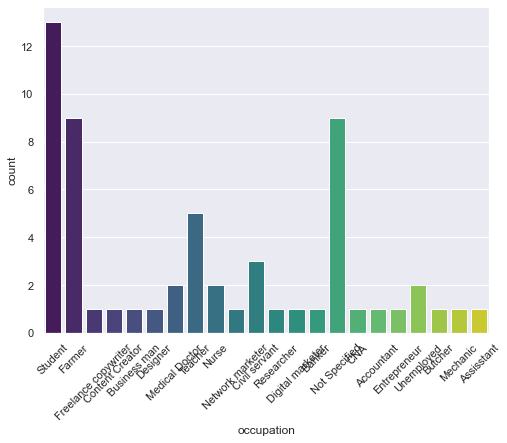

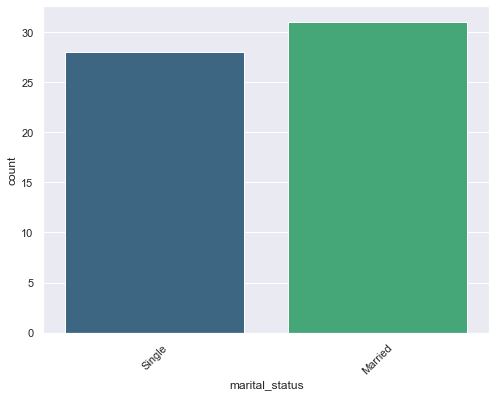

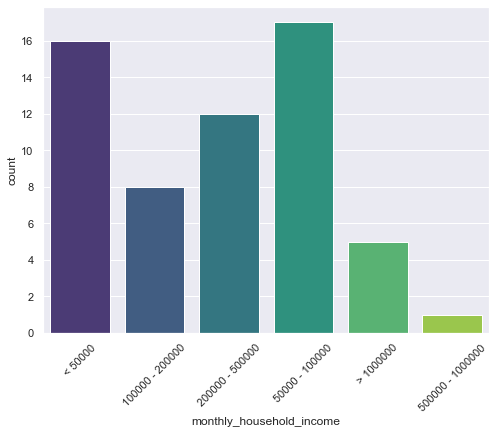

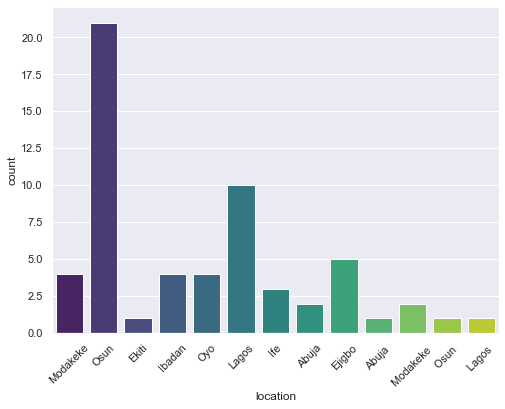

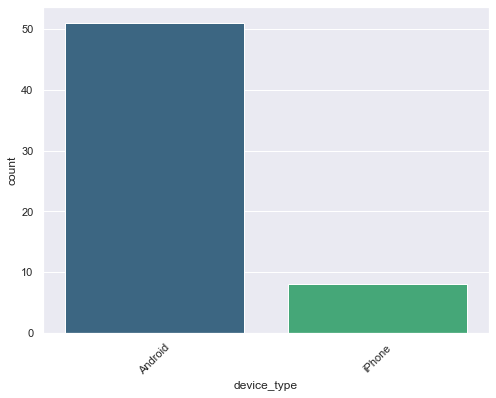

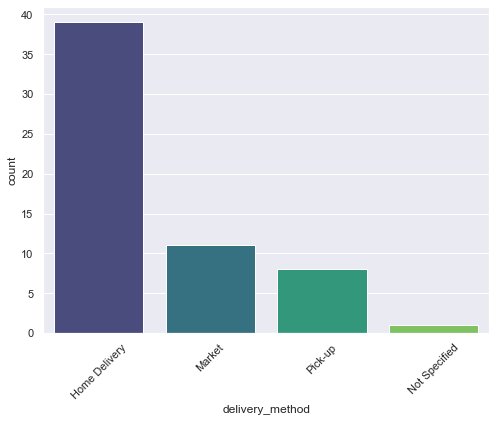

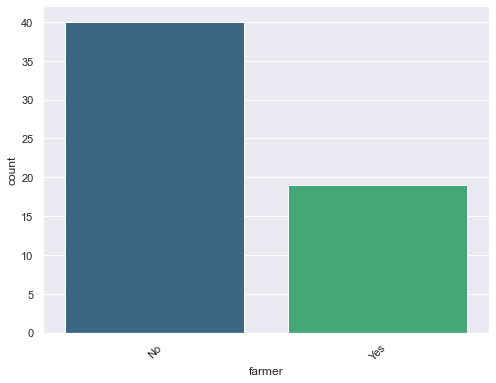

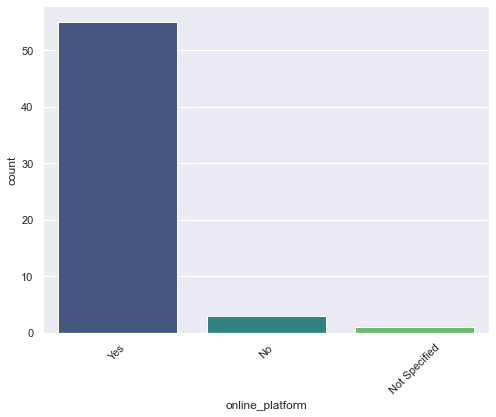

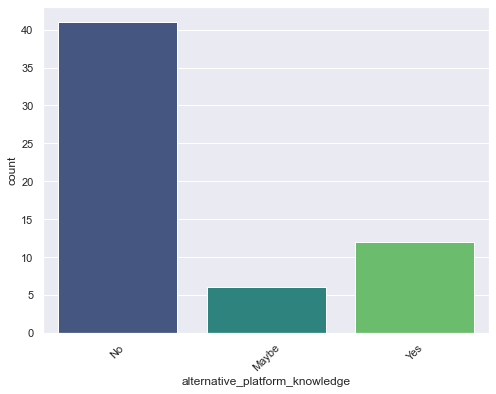

In [8]:
# excluding features with many unique values
features = ['age_range', 'age', 'gender', 'occupation', 'marital_status',
       'monthly_household_income', 'location', 'device_type',
       'delivery_method', 'farmer', 'online_platform',
       'alternative_platform_knowledge']
# looping through all the features and visualize correspong countplots for each
for f in features:
    sns.countplot(x = f, data = SQL_Query, palette = 'viridis')
    plt.xticks(rotation=45)
    plt.show()

##  Feature Engineering 

In [9]:
# make new features list including other important features
new_features = ['age_range', 'age', 'gender', 'occupation', 'marital_status','income',
       'monthly_household_income', 'location', 'device_type',
       'delivery_method', 'farmer','farm_produce', 'online_platform',
       'alternative_platform_knowledge']

In [10]:
# changing categorical variables into numerical attributes

print(SQL_Query.shape)

# choosing columns
data = SQL_Query[new_features]
print(data.shape)

# one hot encoding with get_dummies to change categorical variables into numeric representation
new_data = pd.get_dummies(data, columns = new_features)
# look at new 
print(new_data.shape)
new_data.head()

(59, 14)
(59, 14)
(59, 178)


,age_range_18 - 25,age_range_26 - 35,age_range_35 - 49,age_range_50 and above,age_19,age_20,age_21,age_22,age_23,age_24,...,farm_produce_Vegetables,farm_produce_Vegetables and fruits,"farm_produce_Vegetables,Grains","farm_produce_Vegetables,Rice",online_platform_No,online_platform_Not Specified,online_platform_Yes,alternative_platform_knowledge_Maybe,alternative_platform_knowledge_No,alternative_platform_knowledge_Yes
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


# Model Building

## K-means Clustering

In [11]:
# Initial KMeans model

X_train = new_data.values
# instance of k means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=540)
kmeans = kmeans.fit(X_train)

# Prints the clusters it assigned to each observation
print("The clusters are: ", kmeans.labels_)

# Prints the Inertia
print("The Inertia is: ", kmeans.inertia_)

The clusters are:  [2 1 3 0 0 2 0 2 3 2 0 1 1 2 2 1 3 1 2 3 2 2 0 2 1 0 2 1 2 1 1 1 1 2 0 3 0
 3 2 1 1 1 4 4 1 2 1 1 4 0 4 1 1 3 2 0 0 2 4]
The Inertia is:  399.0425314623457


> Looking for the best inertia

In [12]:
# running KMeans with multiple n_clusters range to 10
no_of_clusters = range(2,11) 
inertia = []

# loop through the clusters to get inertia scores
for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(X_train)
    u = kmeans.inertia_
    inertia.append(u)
    print("The inertia for ", f, "clusters is:", u)

The inertia for  2 clusters is: 464.89976689976686
The inertia for  3 clusters is: 436.6108452950557
The inertia for  4 clusters is: 409.0963910201761
The inertia for  5 clusters is: 396.02029914529913
The inertia for  6 clusters is: 385.37362637362634
The inertia for  7 clusters is: 367.9222222222221
The inertia for  8 clusters is: 360.12857142857143
The inertia for  9 clusters is: 346.39523809523814
The inertia for  10 clusters is: 333.5492063492064


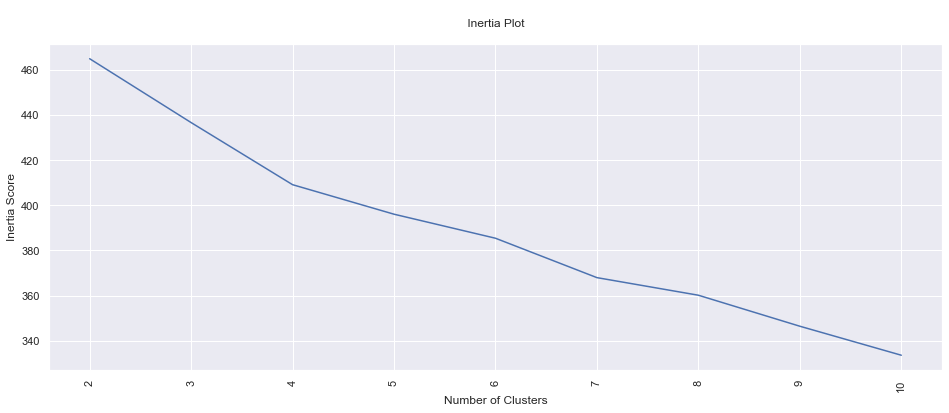

In [13]:
# lineplot of inertia
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.title('\n Inertia Plot \n');

    Plot gets less steep from k= 4-6, so we will take n_clusters = 6

In [14]:
# running KMeans using 6 clusters

kmeans = KMeans(n_clusters=6, random_state=2)
kmeans = kmeans.fit(X_train)
# cluster categories
kmeans.labels_
# predictions for new data
predictions = kmeans.predict(X_train)
# calculating the counts of the cluster
unique, counts = np.unique(predictions, return_counts=True)
counts = counts.reshape(1,6)
# making a df
countscldf = pd.DataFrame(counts, columns = ['Cluster 0','Cluster 1','Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5'])
# display
countscldf

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,13,10,13,8,8,7


> To reduce the dimensions and better visualize the clusters we will build a PCA model.

## Principal Component Analysis (PCA)

Explained variance ratio is : [0.122745 0.075073]


<Figure size 576x432 with 0 Axes>

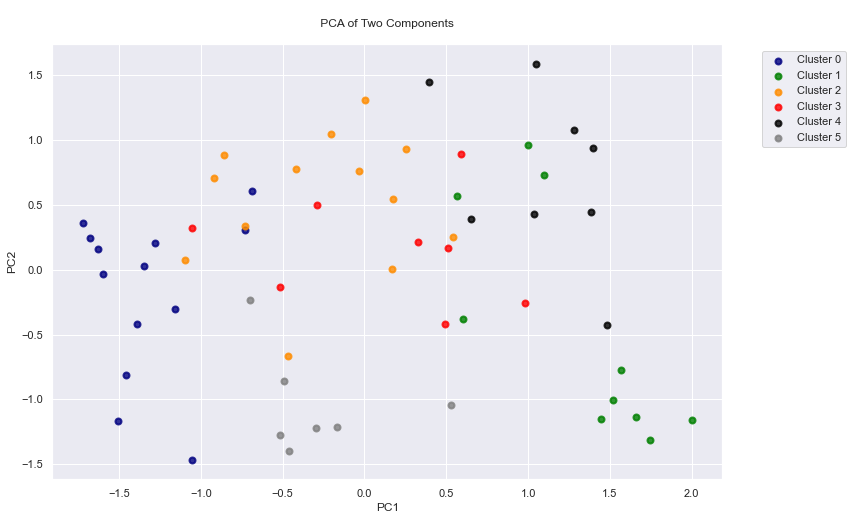

In [15]:
# running PCA to visualize the data (with k=6)

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = X_train
y_num = predictions

target_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

pca = PCA(n_components=2, random_state = 42)
X_r = pca.fit(X).transform(X)


# percentage of variance explained for each component
print('Explained variance ratio is : %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'green', 'darkorange', 'red', 'black', 'gray']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6) 
plt.xlabel('PC1'),
plt.ylabel('PC2'),
plt.title('\n PCA of Two Components \n')
plt.show();

    Explaining about 15% of the data, the subgroups are 6 and are centered around 6 centroids.

In [16]:
X.shape
X_r.shape

(59, 2)

### Rerunning last model and appending labels to initial DataFrame

In [17]:
# running PCA with 2 PC
pca = PCA(n_components=2, random_state = 42)
X_r = pca.fit(X).transform(X)

# running Kmeans with k=6
kmeans = KMeans(n_clusters=6, random_state=2)
kmeans = kmeans.fit(X_r)

clusters = kmeans.labels_

# attaching the clusters back to our initial dataset
SQL_Query['clusters'] = clusters

# Creating a cluster Category
SQL_Query['sub_groups'] = 'No Data'
SQL_Query['sub_groups'].loc[SQL_Query['clusters'] == 0] = 'Group 1'
SQL_Query['sub_groups'].loc[SQL_Query['clusters'] == 1] = 'Group 2'
SQL_Query['sub_groups'].loc[SQL_Query['clusters'] == 2] = 'Group 3'
SQL_Query['sub_groups'].loc[SQL_Query['clusters'] == 3] = 'Group 4'
SQL_Query['sub_groups'].loc[SQL_Query['clusters'] == 4] = 'Group 5'
SQL_Query['sub_groups'].loc[SQL_Query['clusters'] == 5] = 'Group 6'

SQL_Query.head(5)

,age_range,age,gender,occupation,marital_status,income,monthly_household_income,location,device_type,delivery_method,farmer,farm_produce,online_platform,alternative_platform_knowledge,clusters,sub_groups
0,18 - 25,21,Female,Student,Single,5000.0,< 50000,Modakeke,Android,Home Delivery,No,"Garri,Rice,Pepper,Onion,Vegetables",Yes,No,5,Group 6
1,50 and above,57,Female,Student,Married,120000.0,100000 - 200000,Osun,Android,Home Delivery,No,"Pepper, Vegetables, Plantain, Charcoal, Yam fl...",Yes,No,4,Group 5
2,50 and above,57,Male,Farmer,Married,155000.0,100000 - 200000,Osun,Android,Home Delivery,Yes,Cocoa,Yes,No,3,Group 4
3,18 - 25,23,Male,Student,Single,15000.0,< 50000,Ekiti,Android,Home Delivery,No,"Vegetables,Rice",Yes,Maybe,0,Group 1
4,26 - 35,28,Male,Freelance copywriter,Single,300000.0,200000 - 500000,Ibadan,Android,Home Delivery,No,"Vegetables,Grains",Yes,No,0,Group 1


In [18]:
# look at all columns including labels
SQL_Query.columns

Index(['age_range', 'age', 'gender', 'occupation', 'marital_status', 'income',
       'monthly_household_income', 'location', 'device_type',
       'delivery_method', 'farmer', 'farm_produce', 'online_platform',
       'alternative_platform_knowledge', 'clusters', 'sub_groups'],
      dtype='object')

> Export the data back sql server in a new table

In [19]:
#%pip install sqlalchemy

In [20]:
# connecting to the Server and sending SQL_Query trained back to Server with labels as a new table.

from sqlalchemy import create_engine
import urllib

quoted = urllib.parse.quote_plus("Driver={SQL Server};"
                     "Server=DESKTOP-A819NEQ\SQLEXPRESS;"
                     "Database=Women Techsters;"
                     "Trusted_Connection=yes;")

engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

SQL_Query.to_sql('frd_trained', schema='dbo', con = engine, if_exists = 'replace')

-1

In [21]:
# Exporting the data in a CSV

SQL_Query.to_csv('frd_trained', sep='\t')

### Tables and view in the SQL Server

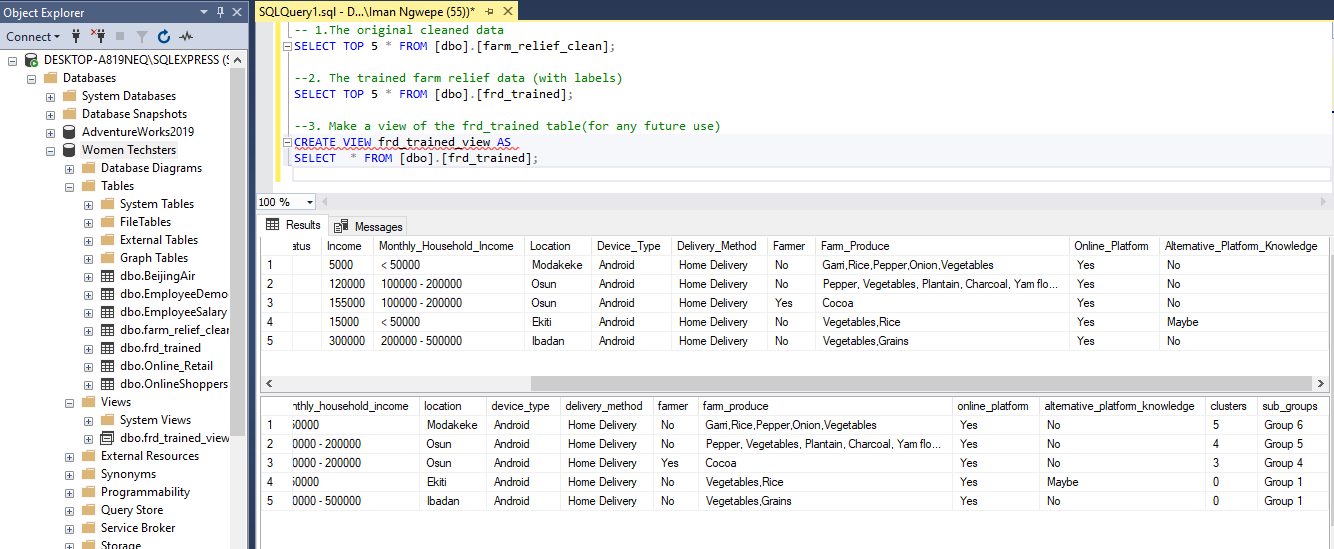

In [22]:
import os
from IPython.display import Image
Image('fr_sql.png', width=900, height=900)

# Summary

All the entries from the survey are put into individual groups according to the 6 clusters. 

## Saving the model

In [23]:
import pickle

In [24]:
# saving kmeans model
filename = 'trained_model.sav'
pickle.dump(kmeans, open(filename, 'wb'))